In [1]:
# Cell A: install and imports
!pip install --quiet scikit-learn joblib

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import joblib


In [2]:
# Cell B: load and inspect
DATAFILE = 'phishing_data.csv'   # change name if needed
df = pd.read_csv(DATAFILE)
print("Shape:", df.shape)
display(df.head(6))
print("Columns:", df.columns.tolist())
# print last column value counts to find class label
print("Last column value counts (quick check):")
print(df.iloc[:, -1].value_counts())


Shape: (11055, 32)


,index,having_IPhaving_IP_Address,URLURL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,1,-1,1,1,1,-1,-1,-1,-1,-1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,2,1,1,1,1,1,-1,0,1,-1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,3,1,0,1,1,1,-1,-1,-1,-1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,4,1,0,1,1,1,-1,-1,-1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,5,1,0,-1,1,1,-1,1,1,-1,...,-1,1,-1,-1,0,-1,1,1,1,1
5,6,-1,0,-1,1,-1,-1,1,1,-1,...,1,1,1,1,1,-1,1,-1,-1,1


Columns: ['index', 'having_IPhaving_IP_Address', 'URLURL_Length', 'Shortining_Service', 'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix', 'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length', 'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor', 'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL', 'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe', 'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank', 'Google_Index', 'Links_pointing_to_page', 'Statistical_report', 'Result']
Last column value counts (quick check):
Result
 1    6157
-1    4898
Name: count, dtype: int64


In [3]:
# Cell C: create label & features (edit class_col if needed)
# If your label column is not 'Result', replace class_col below with the correct name you saw above.
class_col = 'Result' if 'Result' in df.columns else df.columns[-1]
print("Using class column:", class_col)
# Map labels to 0/1 (common formats: {1,-1} or {1,0})
unique_vals = set(df[class_col].unique())
print("unique class values:", unique_vals)

if unique_vals >= {1, -1}:
    df['label'] = df[class_col].map({1:1, -1:0})
elif unique_vals >= {0, 1}:
    df['label'] = df[class_col].map({1:1, 0:0})
else:
    # fallback (rare)
    df['label'] = (df[class_col] == df[class_col].unique()[0]).astype(int)

# Drop obvious non-numeric columns if present
non_feat = [c for c in df.columns if c.lower() in ['url','index','id']]
df = df.drop(columns=[c for c in non_feat if c in df.columns], errors='ignore')

X = df.drop(columns=[class_col,'label'], errors='ignore')
y = df['label'].astype(int)
print("Features shape:", X.shape, "Labels distribution:\n", y.value_counts())


Using class column: Result
unique class values: {np.int64(1), np.int64(-1)}
Features shape: (11055, 30) Labels distribution:
 label
1    6157
0    4898
Name: count, dtype: int64


In [4]:
# Cell D: scale and select K best features
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

K = 6   # top features we will keep
selector = SelectKBest(score_func=chi2, k=K)
# chi2 needs non-negative values -> use abs if features in -1/0/1 format
selector.fit(np.abs(X_scaled), y)
selected_idx = selector.get_support(indices=True)
selected_features = X.columns[selected_idx].tolist()
print(f"Top {K} features (chi2):", selected_features)

# Cross-check with RandomForest importances
rf_check = RandomForestClassifier(n_estimators=100, random_state=42)
rf_check.fit(X_scaled, y)
importances = pd.Series(rf_check.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)
print("Top 10 features by RandomForest importance:\n", importances)


Top 6 features (chi2): ['Prefix_Suffix', 'SSLfinal_State', 'Domain_registeration_length', 'URL_of_Anchor', 'SFH', 'web_traffic']
Top 10 features by RandomForest importance:
 SSLfinal_State                 0.318529
URL_of_Anchor                  0.262463
web_traffic                    0.070082
having_Sub_Domain              0.060848
Links_in_tags                  0.041492
Prefix_Suffix                  0.038782
SFH                            0.020772
Request_URL                    0.019452
Links_pointing_to_page         0.019059
Domain_registeration_length    0.016344
dtype: float64


In [5]:
# Cell E: train & evaluate using selected features
X_sel = X_scaled[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.2, stratify=y, random_state=42)

models = {
    "LogisticRegression": LogisticRegression(max_iter=500),
    "RandomForest": RandomForestClassifier(n_estimators=150, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    results[name] = {
        "accuracy": round(accuracy_score(y_test, y_pred), 4),
        "precision": round(precision_score(y_test, y_pred, zero_division=0), 4),
        "recall": round(recall_score(y_test, y_pred, zero_division=0), 4),
        "f1": round(f1_score(y_test, y_pred, zero_division=0), 4),
        "auc": round(roc_auc_score(y_test, y_prob), 4) if y_prob is not None else None
    }
    print(f"\n{name} ->", results[name])
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))



LogisticRegression -> {'accuracy': 0.9186, 'precision': 0.9027, 'recall': 0.9569, 'f1': 0.929, 'auc': np.float64(0.972)}
Confusion matrix:
 [[ 853  127]
 [  53 1178]]

RandomForest -> {'accuracy': 0.9222, 'precision': 0.9173, 'recall': 0.9456, 'f1': 0.9312, 'auc': np.float64(0.9828)}
Confusion matrix:
 [[ 875  105]
 [  67 1164]]


Best model by F1: RandomForest
Saved model and scaler.


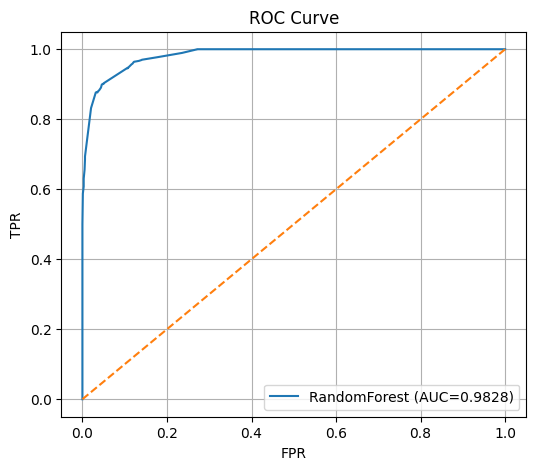

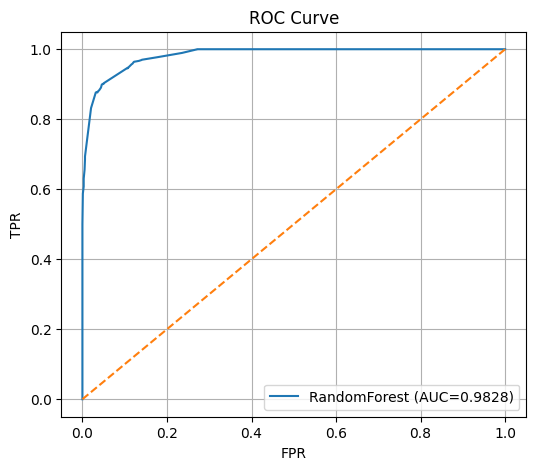

In [6]:
# Cell F: save best model and plot ROC
best_name = max(results.keys(), key=lambda n: results[n]['f1'])
print("Best model by F1:", best_name)
best_model = models[best_name]
joblib.dump(best_model, f"{best_name}_model.joblib")
joblib.dump(scaler, "scaler.joblib")
print("Saved model and scaler.")

if hasattr(best_model, "predict_proba"):
    y_prob = best_model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"{best_name} (AUC={results[best_name]['auc']})")
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.savefig("roc_curve.png", bbox_inches='tight')
    display(plt.gcf())
